In [218]:
import sys
print(sys.version)

3.5.3 |Anaconda 4.4.0 (x86_64)| (default, Mar  6 2017, 12:15:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [285]:
# load dependencies
import pandas as pd
import io
import requests
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from hpsklearn import HyperoptEstimator, any_classifier
from sklearn.datasets import fetch_mldata
from hyperopt import tpe

# reference: 
# https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


### Table of Content
1. [Goal of This Project](#section1)
2. [Golden Rule of Machine Learning](#section2)
3. [Exploratory Data Analysis (EDA)](#section3)
4. [Reflection of EDA](#section4)
5. [More Data Wrangling](#section5)
6. [kNN Classifier](#section6)
7. 


<a id="section1"></a>
### 1. Goal of This Project

I plan to go to Las Vegas with my undergrad buddies in June 2018. To ensure that we have a good time there, my goal is to find the best features to classify good and bad hotels. I will use my findings help me book a hotel for my trip.

Data Source: [UCI Machine Learning Repository: Las Vegas Strip Data Set](http://archive.ics.uci.edu/ml/datasets/Las+Vegas+Strip)

<a id="section2"></a>
### 2. Follow the "Golden Rule of Machine Learning"

Retrieve the data set from the source and set a side some data instances as a test set. I will only inspect the training data set.

In [220]:
# load the data
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00397/LasVegasTripAdvisorReviews-Dataset.csv"
raw_dataframe = pd.read_csv(url, delimiter=';')
# reference:
# https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url/41880513#41880513

# shuffle the array (in case it is sorted)
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
np.random.seed(123)
raw_dataframe = shuffle(raw_dataframe)

# split raw data frame into two sets
training_dataframe = raw_dataframe[:336]
test_datafram = raw_dataframe[336:]

# view the first 2 rows of raw data frame
training_dataframe.head(2)

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
429,Australia,43,38,29,5,Sep-Nov,Couples,YES,YES,NO,YES,YES,YES,The Venetian Las Vegas Hotel,5,4027,Oceania,4,November,Saturday
282,USA,12,5,1,5,Sep-Nov,Couples,YES,YES,NO,YES,YES,YES,Encore at wynn Las Vegas,5,2034,North America,5,October,Friday


<a id="section1"></a>
### 3. Exploratory data analysis

I should learn more about the data set then start my feature selection with a deeper understanding of the data set.

In [221]:
training_dataframe.info()

# reference: 
# https://github.com/ubcs3/2017-Fall/blob/master/notes-2017-10-06/notes-2017-10-06.ipynb

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 429 to 169
Data columns (total 20 columns):
User country         336 non-null object
Nr. reviews          336 non-null int64
Nr. hotel reviews    336 non-null int64
Helpful votes        336 non-null int64
Score                336 non-null int64
Period of stay       336 non-null object
Traveler type        336 non-null object
Pool                 336 non-null object
Gym                  336 non-null object
Tennis court         336 non-null object
Spa                  336 non-null object
Casino               336 non-null object
Free internet        336 non-null object
Hotel name           336 non-null object
Hotel stars          336 non-null object
Nr. rooms            336 non-null int64
User continent       336 non-null object
Member years         336 non-null int64
Review month         336 non-null object
Review weekday       336 non-null object
dtypes: int64(6), object(14)
memory usage: 55.1+ KB


In [222]:
training_dataframe["Hotel name"].value_counts()

Trump International Hotel Las Vegas                    19
The Palazzo Resort Hotel Casino                        19
Bellagio Las Vegas                                     19
The Cosmopolitan Las Vegas                             19
The Venetian Las Vegas Hotel                           19
The Westin las Vegas Hotel Casino & Spa                18
Wyndham Grand Desert                                   18
Encore at wynn Las Vegas                               18
Wynn Las Vegas                                         17
Caesars Palace                                         16
Excalibur Hotel & Casino                               16
Circus Circus Hotel & Casino Las Vegas                 16
Treasure Island- TI Hotel & Casino                     16
Hilton Grand Vacations at the Flamingo                 15
Monte Carlo Resort&Casino                              14
Paris Las Vegas                                        14
Hilton Grand Vacations on the Boulevard                14
Tropicana Las 

> Hotels are pretty evenly reviewed by customers.

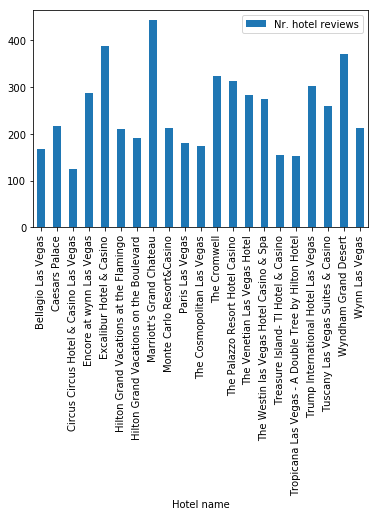

In [223]:
training_dataframe.groupby("Hotel name").sum().plot.bar(y="Nr. hotel reviews")

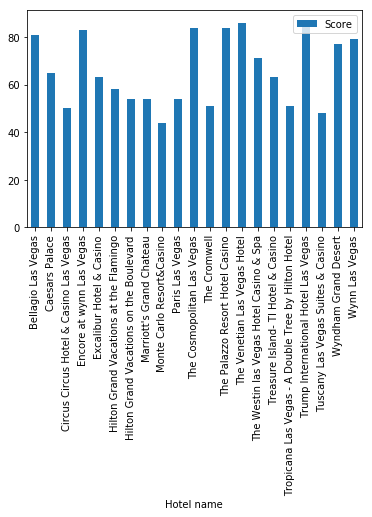

In [224]:
training_dataframe.groupby("Hotel name").sum().plot.bar(y="Score")

> Looking at the sum of hotel reviews, I realize that there is a big gap between the highest-rated hotel and the lowest. Looking at the sum of scores however, the gap is not very wide. "Trump International Hotel Las Vegas" seems to be the best rated hotel.

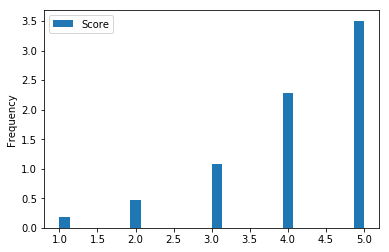

In [225]:
training_dataframe.plot.hist(y="Score", bins=30, normed=True)
plt.show()

> Most hotels seem to be in the 5.0 range.

In [226]:
training_dataframe["User country"].value_counts()

USA             162
UK               45
Canada           37
Australia        23
Ireland          10
India             7
Germany           5
New Zeland        5
Malaysia          3
Netherlands       3
Mexico            3
Egypt             3
Singapore         2
Brazil            2
Norway            2
Costa Rica        2
Thailand          2
Finland           2
Scotland          2
Israel            2
Croatia           1
Spain             1
Kuwait            1
South Africa      1
Puerto Rico       1
Belgium           1
Italy             1
Kenya             1
Hawaii            1
Switzerland       1
China             1
Taiwan            1
Saudi Arabia      1
Swiss             1
Name: User country, dtype: int64

> Most of the reviews are done by US customers. They may or may not reflect Canadian taste.

In [227]:
training_dataframe["Traveler type"].value_counts()

Couples     143
Families     71
Friends      62
Business     44
Solo         16
Name: Traveler type, dtype: int64

> Most of the reviews are done by couples. My group is not in this category. We are in the "friends" category.

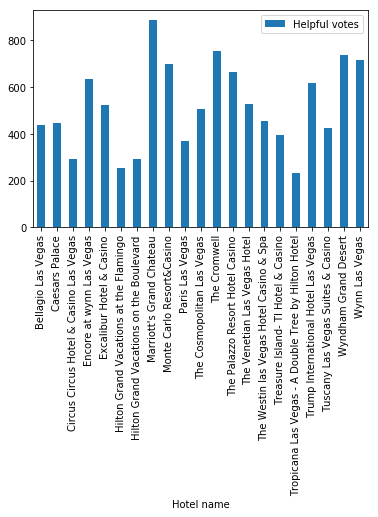

In [228]:
training_dataframe.groupby("Hotel name").sum().plot.bar(y="Helpful votes")
plt.show()

> Reviews of "Marriott's Grand Chateau" received the most helpful votes.

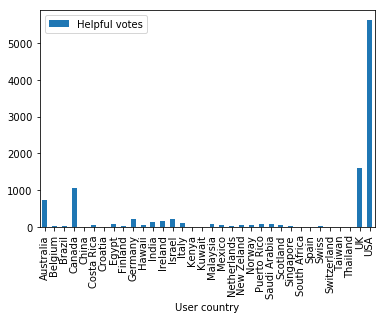

In [229]:
training_dataframe.groupby("User country").sum().plot.bar(y="Helpful votes")
plt.show()

> Reviews submitted by US, UK, Canadian, and Australian customers received the most helpful votes.

<a id="section4"></a>
### 4. Reflection after EDA
- Most of the reviews collected in this data set are from US customers and most reviewers are couples. Insight from this data set may not apply to my friends. 
- Most hotels are in the 5.0 and 4.0 range. I think that is reassuring. Most customers give good scores. 
- Is "Trump International Hotel Las Vegas" really the best?

<a id="section5"></a>
### 5. More Data Wrangling Needed

I realize that most features in this data set are categorical. I need to convert them into dummy variables so I can build a better model.

In [230]:
#redo data wrangling with dummies
raw_dataframe = pd.get_dummies(raw_dataframe)

raw_dataframe.head(2)

,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Nr. rooms,Member years,User country_Australia,User country_Belgium,User country_Brazil,User country_Canada,...,Review month_November,Review month_October,Review month_September,Review weekday_Friday,Review weekday_Monday,Review weekday_Saturday,Review weekday_Sunday,Review weekday_Thursday,Review weekday_Tuesday,Review weekday_Wednesday
429,43,38,29,5,4027,4,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
282,12,5,1,5,2034,5,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [231]:
# convert data frame to numpy array
raw_data = raw_dataframe.values

# split into 2 sets
training_set = raw_data[:336]
test_set = raw_data[336:]

# take out the "score" label
# reference:
# https://stackoverflow.com/questions/8386675/extracting-specific-columns-in-numpy-array
training_label = training_set[:, [43]].flatten()
test_label = test_set[:, [3]].flatten()

X = np.delete(training_set, 3, 1)
Xtest = np.delete(test_set, 3, 1)

> Now we are ready for some machine learning. 

<a id="section6"></a>
### 6. kNN Classifier

> First, I will try to fit a kNN to establish a baseline for my model and feature selection.

In [286]:
# randomly split into training and validaiton set
Xtrain, Xval, ytrain, yval = train_test_split(X, training_label, 
                                                          test_size=0.50, 
                                                          random_state=123)

In [294]:
neighbour_candidate_list = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

kNN_training_score_list = []

kNN_validation_score_list = []

for neighbour_index in neighbour_candidate_list:
    kNN_classifier = KNeighborsClassifier(n_neighbors=neighbour_index, algorithm="brute", p=2)
    kNN_classifier.fit(Xtrain,ytrain)
    kNN_training_score_list.append(kNN_classifier.score(Xtrain, ytrain))
    kNN_validation_score_list.append(kNN_classifier.score(Xval, yval))

In [298]:
kNN_training_score_list


[0.99404761904761907,
 0.99404761904761907,
 0.99404761904761907,
 0.99404761904761907,
 0.99404761904761907,
 0.99404761904761907,
 0.99404761904761907,
 0.99404761904761907,
 0.99404761904761907,
 0.99404761904761907]

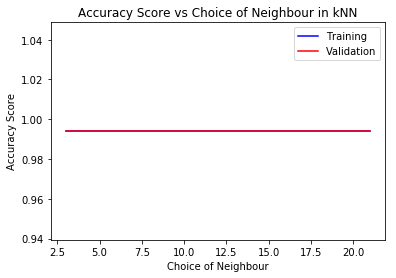

In [299]:
# visualize the result
plt.plot(neighbour_candidate_list, kNN_training_score_list, '-', color='blue')
plt.plot(neighbour_candidate_list, kNN_validation_score_list, '-', color='red')
plt.xlabel("Choice of Neighbour")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs Choice of Neighbour in kNN")
plt.legend(["Training","Validation"])

> kNN classifiers gives a very high accuracy at any number of neighbour given.